#### 라이브러리 불러오기

In [2]:
import os
import datetime

import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf

mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False
from tensorflow.keras.callbacks import EarlyStopping

from climate_win_gen import WindowGen

2023-08-30 19:05:16.140917: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


#### 전처리 데이터 불러오기

In [3]:
_PATH_BASE = os.path.join(os.getcwd(), 'data')
_PATH_TRAIN = os.path.join(_PATH_BASE, 'b_train.csv')
_PATH_VALID = os.path.join(_PATH_BASE, 'b_valid.csv')
_PATH_TEST = os.path.join(_PATH_BASE, 'b_test.csv')

try:
    df_train = pd.read_csv(_PATH_TRAIN)
    df_valid = pd.read_csv(_PATH_VALID)
    df_test = pd.read_csv(_PATH_TEST)
except Exception as e:
    print('훈련/검증/시험파일이 존재하지 않습니다.\n'
          '52-ts-climate-pp.ipynb 실행 후 작업하시기 바랍니다.')
    print(e)

#### 랩핑함수 생성

In [12]:
target_columns = 'ACTIVE_POWER'

In [4]:
column_indices = {name: i for i, name in enumerate(df_train.columns)}

def make_win(input_width, label_width, shift, labels):
    return WindowGen(
        input_width=input_width,
        label_width=label_width,
        shift=shift,
        df_train=df_train,
        df_valid=df_valid,
        df_test=df_test,
        label_columns=labels
    )

#### fit함수 정의

In [8]:
MAX_EPOCHS = 20

def compile_and_fit(model, window, patience=2):
    early_stopping = EarlyStopping(
        monitor='val_loss', patience=patience, mode='min'
    )
    model.compile(
        optimizer=tf.keras.optimizers.Adam(),
        loss=tf.keras.losses.MeanSquaredError(),
        metrics=[tf.keras.metrics.MeanAbsoluteError()]
    )
    
    return model.fit(       # return history
        window.train, 
        epochs=MAX_EPOCHS, 
        validation_data=window.valid,
        callbacks=[early_stopping]
    )

#### 모델링

In [5]:
OUT_STEPS = 24
multi_window = make_win(
    input_width=24, label_width=OUT_STEPS, shift=OUT_STEPS, 
    labels=['ACTIVE_POWER']
)
multi_window

Total window size: 48
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label indices: [24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47]
Label column name(s): ['ACTIVE_POWER']

In [10]:
num_features = df_train.shape[1]

multi_val_performance = {}
multi_performance = {}

139/139 [==============================] - 0s 1ms/step - loss: 1.0506 - mean_absolute_error: 0.7023


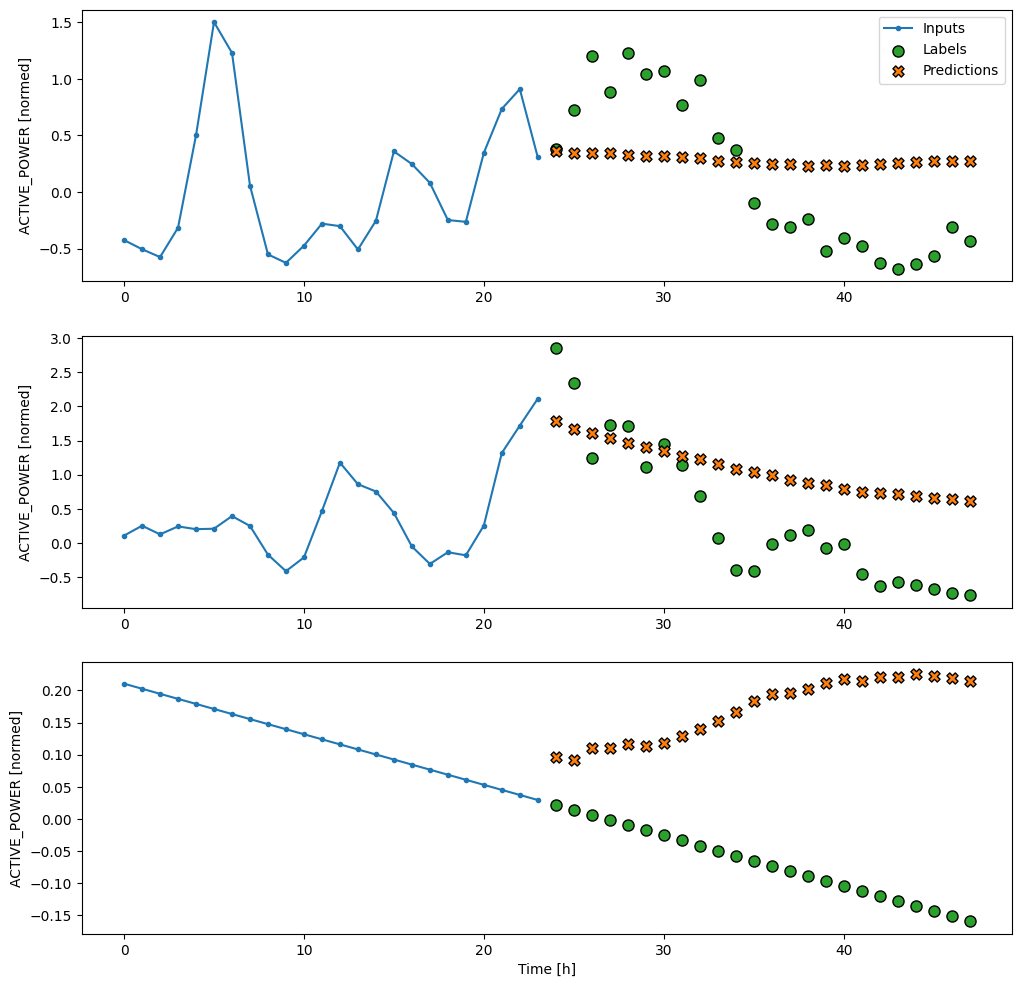

In [13]:
multi_linear_model = tf.keras.Sequential([
    # Take the last time-step.
    # Shape [batch, time, features] => [batch, 1, features]
    tf.keras.layers.Lambda(lambda x: x[:, -1:, :]),
    # Shape => [batch, 1, out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_linear_model, multi_window)

IPython.display.clear_output()
multi_val_performance['Linear'] = multi_linear_model.evaluate(multi_window.valid)
multi_performance['Linear'] = multi_linear_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(multi_linear_model, plot_col=target_columns)

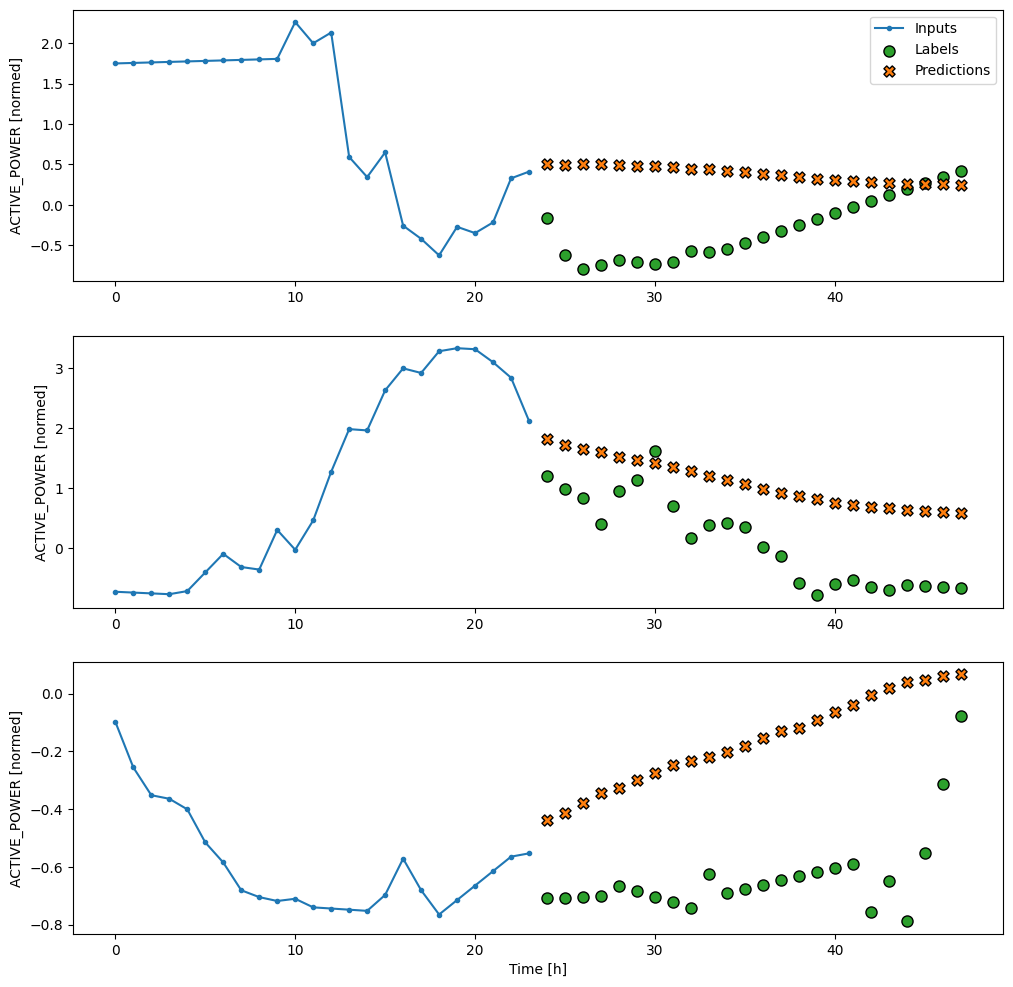

In [14]:
multi_window.plot(multi_linear_model, plot_col=target_columns, start=1000)

139/139 [==============================] - 0s 2ms/step - loss: 1.0797 - mean_absolute_error: 0.6808


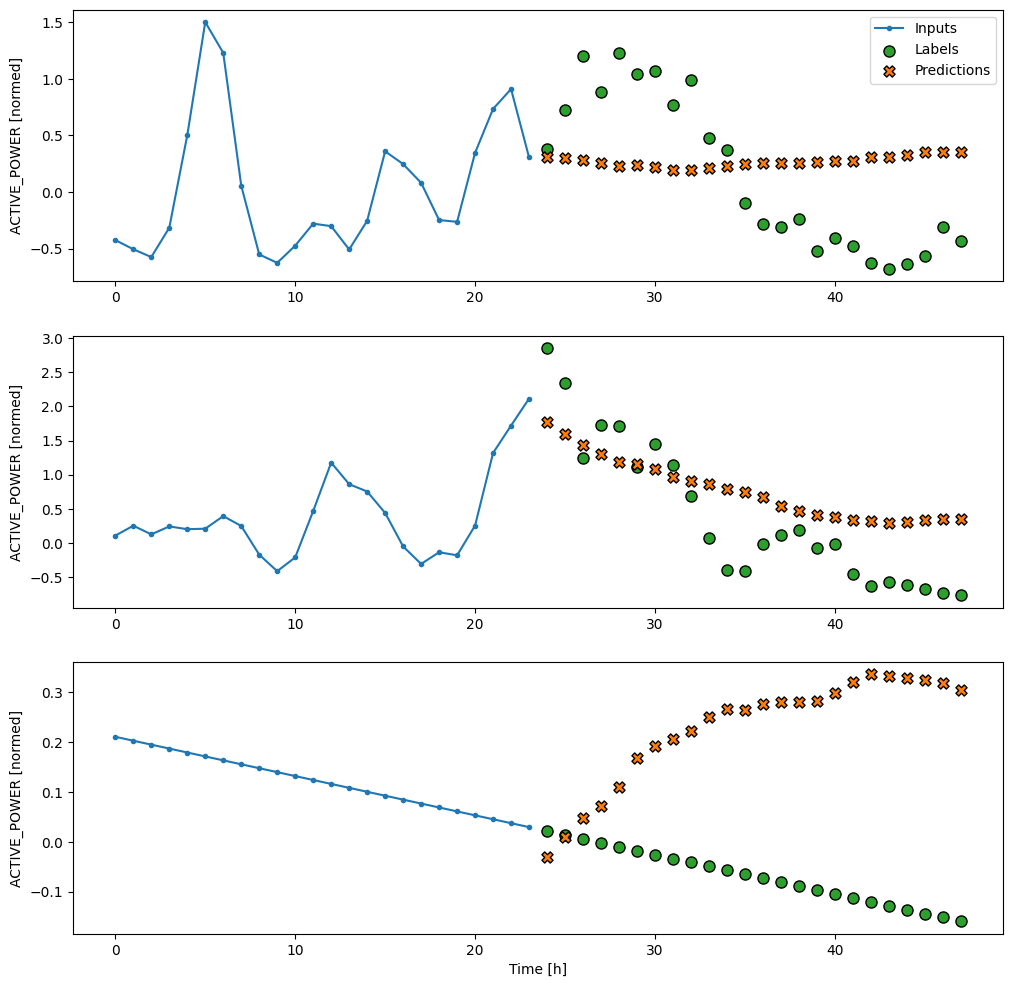

In [15]:
multi_dense_model = tf.keras.Sequential([
    # Take the last time step.
    # Shape [batch, time, features] => [batch, 1, features]
    tf.keras.layers.Lambda(lambda x: x[:, -1:, :]),
    # Shape => [batch, 1, dense_units]
    tf.keras.layers.Dense(512, activation='relu'),
    # Shape => [batch, out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_dense_model, multi_window)

IPython.display.clear_output()
multi_val_performance['Dense'] = multi_dense_model.evaluate(multi_window.valid)
multi_performance['Dense'] = multi_dense_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(multi_dense_model, plot_col=target_columns)

139/139 [==============================] - 0s 2ms/step - loss: 1.0533 - mean_absolute_error: 0.6961


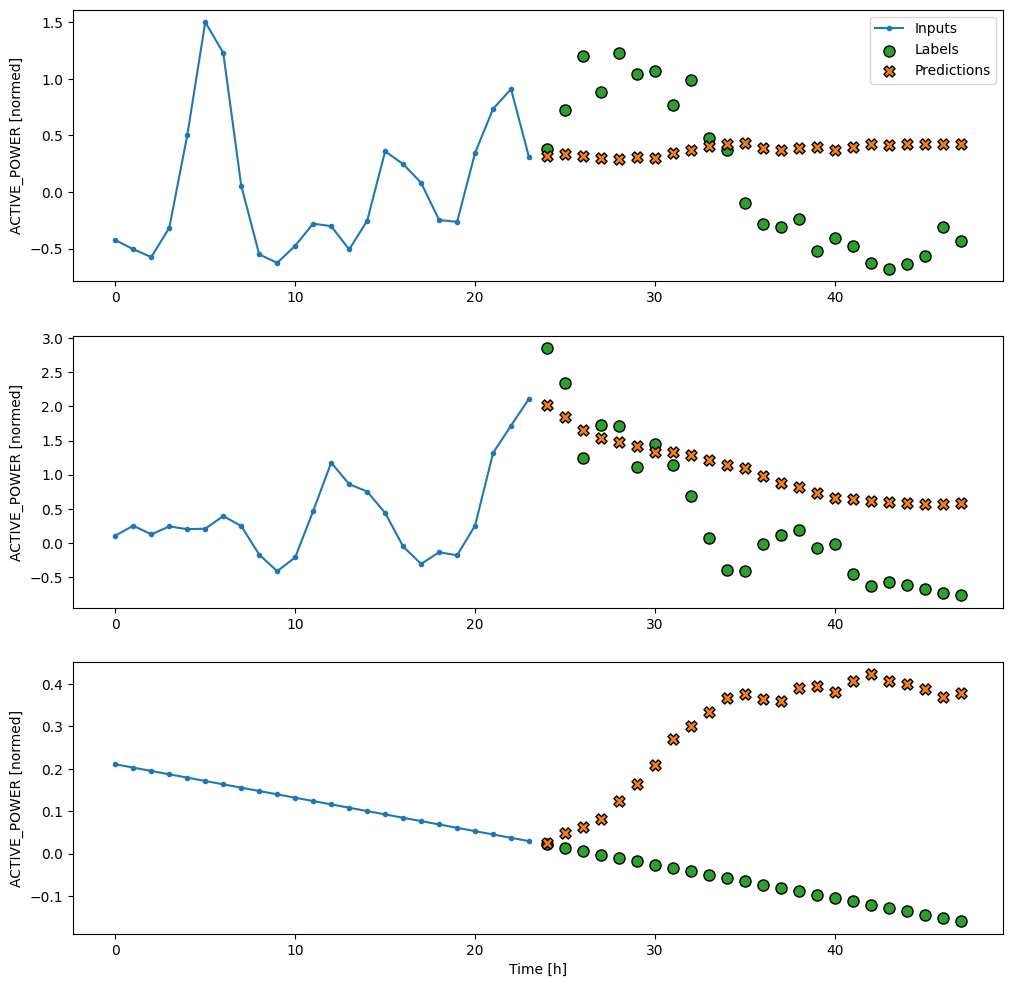

In [16]:
CONV_WIDTH = 3
multi_conv_model = tf.keras.Sequential([
    # Shape [batch, time, features] => [batch, CONV_WIDTH, features]
    tf.keras.layers.Lambda(lambda x: x[:, -CONV_WIDTH:, :]),
    # Shape => [batch, 1, conv_units]
    tf.keras.layers.Conv1D(256, activation='relu', kernel_size=(CONV_WIDTH)),
    # Shape => [batch, 1,  out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_conv_model, multi_window)

IPython.display.clear_output()

multi_val_performance['Conv'] = multi_conv_model.evaluate(multi_window.valid)
multi_performance['Conv'] = multi_conv_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(multi_conv_model, plot_col=target_columns)

139/139 [==============================] - 0s 2ms/step - loss: 1.1178 - mean_absolute_error: 0.7084


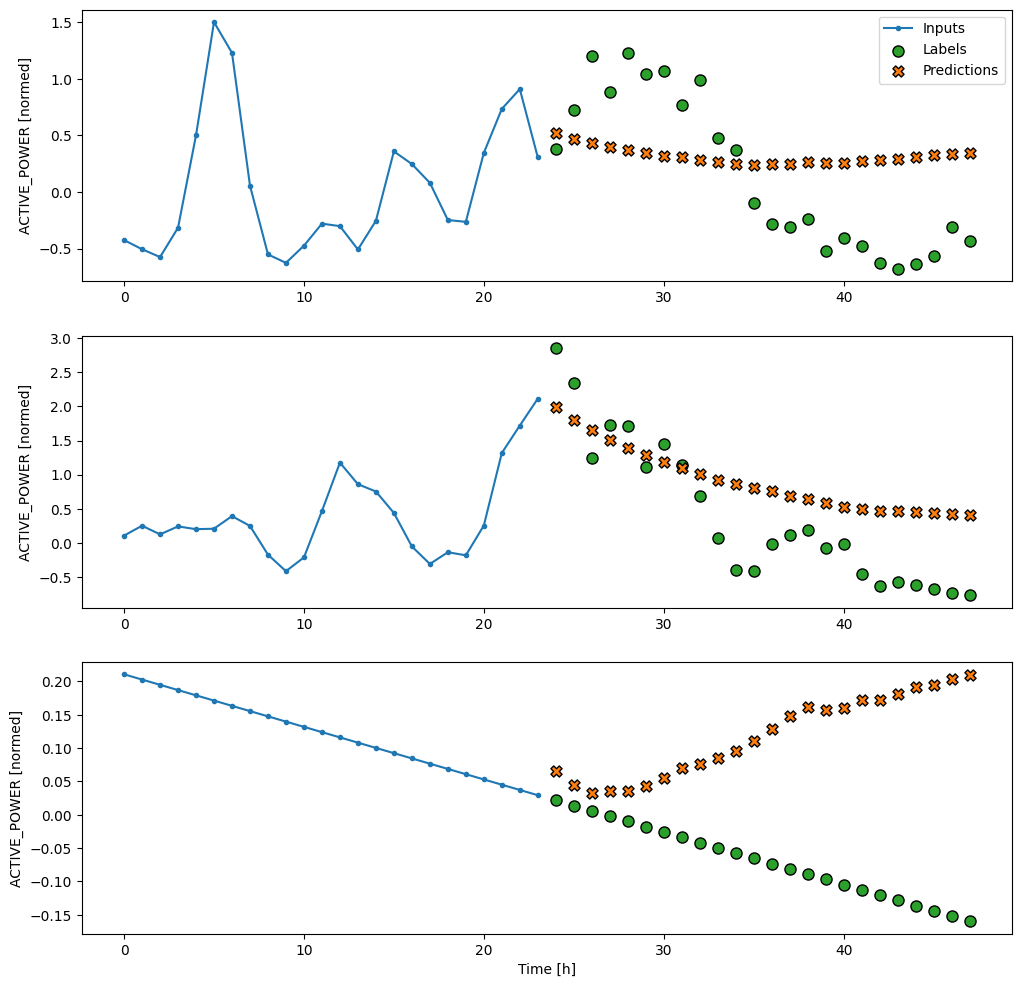

In [22]:
multi_lstm_model = tf.keras.Sequential([
    # Shape [batch, time, features] => [batch, lstm_units].
    # Adding more `lstm_units` just overfits more quickly.
    tf.keras.layers.LSTM(32, return_sequences=False),
    # Shape => [batch, out_steps*features].
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features].
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_lstm_model, multi_window)

IPython.display.clear_output()

multi_val_performance['LSTM'] = multi_lstm_model.evaluate(multi_window.valid)
multi_performance['LSTM'] = multi_lstm_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(multi_lstm_model, plot_col=target_columns)

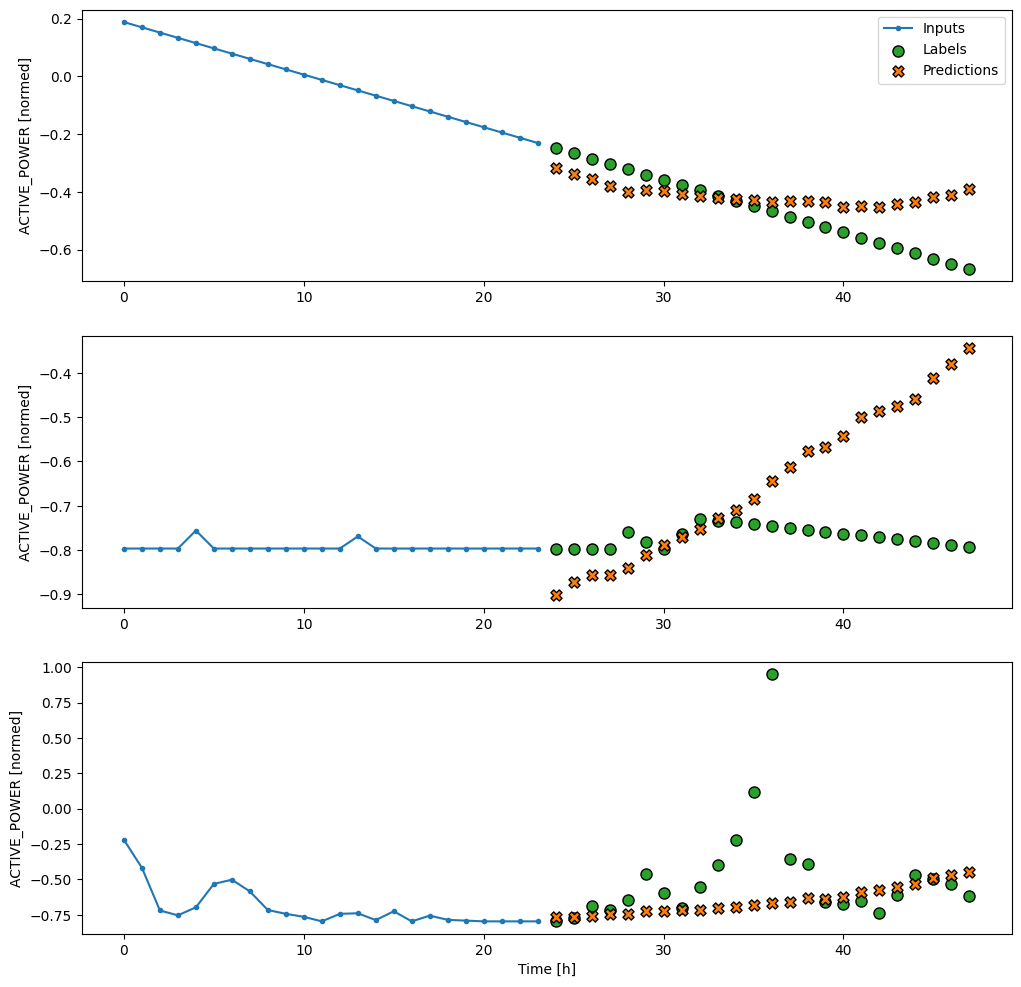

In [19]:
multi_window.plot(multi_lstm_model, plot_col=target_columns, start=4000)

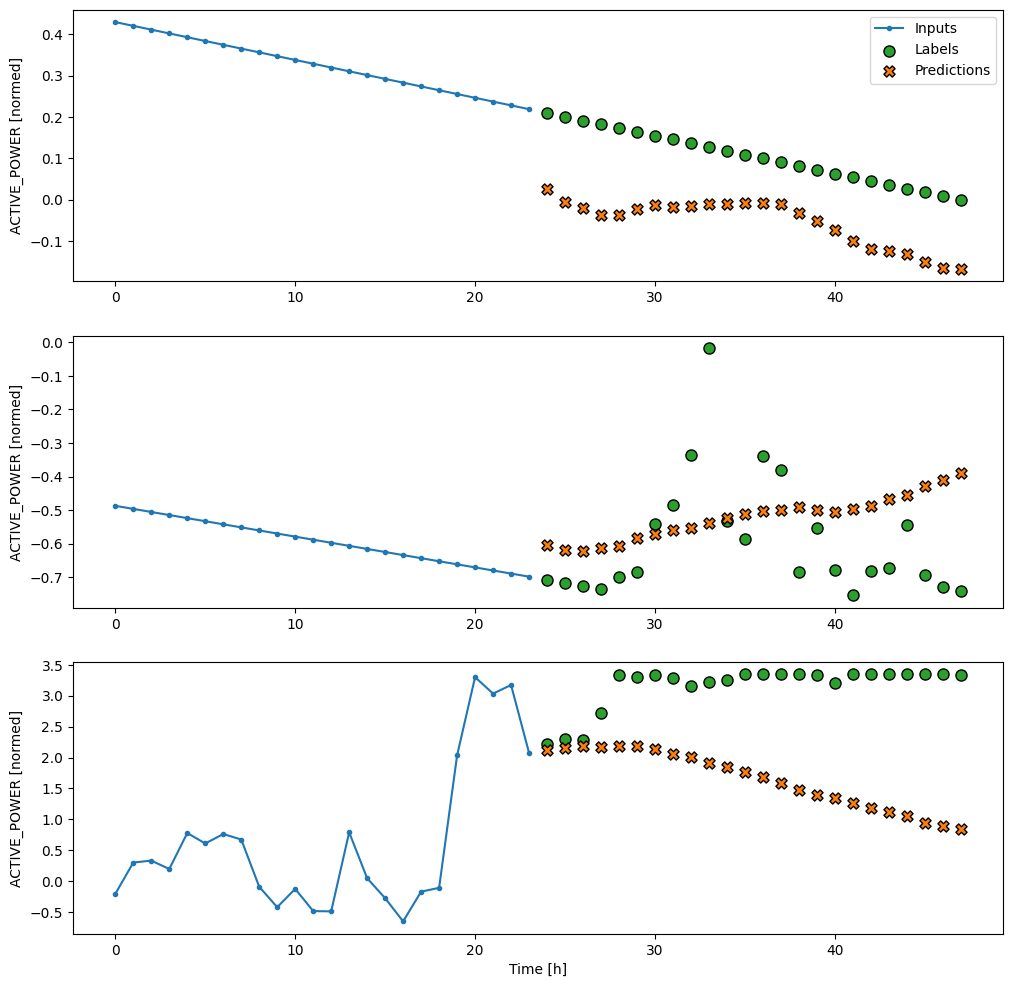

In [21]:
multi_window.plot(multi_lstm_model, plot_col=target_columns, start=1500)